In [1]:
import os
import pickle
import time 
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import tensorflow as tf
import tensorflow_hub as hub
os.environ['TFHUB_DOWNLOAD_PROGRESS']='True'

In [19]:
import requests
PATH = 'sample/dog.jpg'
with open(PATH, 'rb') as image_file:
    image_data = image_file.read()

IMAGE_PATH = PATH
SAVED_MODEL_PATH = "https://tfhub.dev/captain-pool/esrgan-tf2/1"

In [20]:
def preprocess_image(image_path):
   '''Loads the image given make it ready for 
      the model
      Args:
        image_path: Path to the image file
   '''
   image = tf.image.decode_image(tf.io.read_file(image_path))
   if image.shape[-1] == 4:
     image = image[...,:-1]
   size = (tf.convert_to_tensor(image.shape[:-1]) // 4) * 4
   image = tf.image.crop_to_bounding_box(image, 0, 0, size[0], size[1])
   image = tf.cast(image,tf.float32)
   return tf.expand_dims(image,0)

def save_image(image,filename):
  ''' 
   Saves unscaled Tensor Images
   image: 3D image Tensor
   filename: Name of the file to be saved
  '''
  if not isinstance(image, Image.Image):
      image = tf.clip_by_value(image, 0, 255)
      image = Image.fromarray(tf.cast(image, tf.uint8).numpy())
  image.save('%s.jpg' % filename)
  print('Saved as %s.jpg' % filename)

In [21]:
preprocess_image(IMAGE_PATH)

<tf.Tensor: shape=(1, 224, 224, 3), dtype=float32, numpy=
array([[[[247., 247., 247.],
         [246., 246., 246.],
         [244., 244., 244.],
         ...,
         [  0.,   0.,   0.],
         [  0.,   0.,   0.],
         [  0.,   0.,   0.]],

        [[243., 243., 243.],
         [242., 242., 242.],
         [242., 242., 242.],
         ...,
         [  6.,   6.,   6.],
         [  0.,   0.,   0.],
         [  0.,   0.,   0.]],

        [[238., 238., 238.],
         [239., 239., 239.],
         [240., 240., 240.],
         ...,
         [ 13.,  13.,  13.],
         [  3.,   3.,   3.],
         [  0.,   0.,   0.]],

        ...,

        [[ 97.,  97.,  97.],
         [ 76.,  76.,  76.],
         [111., 111., 111.],
         ...,
         [ 57.,  55.,  56.],
         [ 13.,  11.,  12.],
         [ 93.,  91.,  92.]],

        [[104., 104., 104.],
         [ 77.,  77.,  77.],
         [ 91.,  91.,  91.],
         ...,
         [ 45.,  43.,  44.],
         [ 23.,  21.,  22.],
         

In [22]:
def plot_image(image,title=''):
  ''' 
  plots the Image tensors
  image: 3D image Tensor
  title: Title for plot
  '''
  image = np.asarray(image)
  image = tf.clip_by_value(image, 0, 255)
  image = Image.fromarray(tf.cast(image, tf.uint8).numpy())
  plt.imshow(image)
  plt.axis('off')
  plt.title(title)

In [23]:
model = hub.load(SAVED_MODEL_PATH)

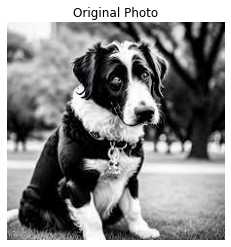

In [24]:
load_image = preprocess_image(IMAGE_PATH)

plot_image(tf.squeeze(load_image),title='Original Photo')

In [25]:
super_image = model(load_image)
super_image = tf.squeeze(super_image)


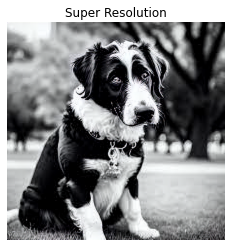

In [26]:
plot_image(tf.squeeze(super_image),'Super Resolution')

In [27]:
IMAGE_PATH = PATH

In [28]:
def downscale_image(image):
  """
      Scales down images using bicubic downsampling.
      Args:
          image: 3D or 4D tensor of preprocessed image
  """
  image_size = []
  if len(image.shape) == 3:
    image_size = [image.shape[1], image.shape[0]]
  else:
    raise ValueError("Dimension mismatch. Can work only on single image.")

  image = tf.squeeze(tf.cast(tf.clip_by_value(image, 0, 255), tf.uint8))

  lr_image = np.asarray(Image.fromarray(image.numpy()).resize([image_size[0] // 4, image_size[1] // 4],Image.BICUBIC))

  lr_image = tf.expand_dims(lr_image, 0)
  lr_image = tf.cast(lr_image, tf.float32)
  return lr_image

In [29]:
hr_image = preprocess_image(IMAGE_PATH)

In [30]:
lr_image = downscale_image(tf.squeeze(hr_image))

C:\Users\SUYOG\AppData\Local\Temp\ipykernel_11880\124301897.py:15: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  lr_image = np.asarray(Image.fromarray(image.numpy()).resize([image_size[0] // 4, image_size[1] // 4],Image.BICUBIC))


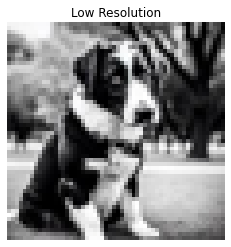

In [14]:
plot_image(tf.squeeze(lr_image), title="Low Resolution")

In [15]:
start = time.time()
fake_image = model(lr_image)
fake_image = tf.squeeze(fake_image)
print("Time Taken: %f" % (time.time() - start))

Time Taken: 1.148531


PSNR Achieved: 23.294180


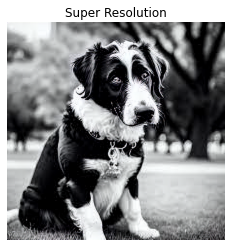

In [16]:
plot_image(tf.squeeze(super_image), title="Super Resolution")
# Calculating PSNR wrt Original Image
psnr = tf.image.psnr(
    tf.clip_by_value(fake_image, 0, 255),
    tf.clip_by_value(hr_image, 0, 255), max_val=255)
print("PSNR Achieved: %f" % psnr)

PSNR: 23.294180


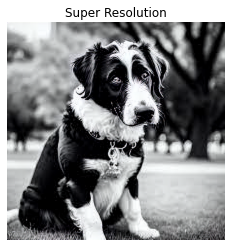

In [17]:
# plt.rcParams['figure.figsize'] = [15, 10]
# fig, axes = plt.subplots(1, 3)
# fig.tight_layout()
# plt.subplot(131)
# plot_image(tf.squeeze(hr_image), title="Original")
# plt.subplot(132)
# fig.tight_layout()
# plot_image(tf.squeeze(lr_image), "x4 Bicubic")
# plt.subplot(133)
# fig.tight_layout()
plot_image(tf.squeeze(super_image), "Super Resolution")
plt.savefig("Super.jpg")
print("PSNR: %f" % psnr)